<a href="https://colab.research.google.com/github/AlanMarquesRocha/t02_ica_rna_mlp_rbf/blob/master/t02_ica_rna_rbf_smote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Programa de Pós-Graduação em Engenharia Elétrica e de Computação (PPGEEC)
### Ingeligência Computacional Aplicada (ICA)
### Trabalho 02 - Redes Neurais Artificiais Perceptron Multicamadas (RNA - MLP) e Redes de Base Radial (RBF)
### Base de dados: ``Predict Students' dropout and academic sucess``
### Discente: Alan Marques da Rocha (543897)
---

#### O conjunto de dados ``Predict Students' dropout and academic sucess`` contém 4.424 instâncias, 36 atributos e três classes distintas, a saber: ``Dropout``, ``Graduate`` e ``Enrolled``.

#### O arquivo está em formato ``.csv`` e pode ser acessado através de um programa de planilhas comum (Excel, calc, Planilhas Google, etc..)

#### A base de dados foi dividida em 80% para treino e 20% para teste.



# **Implementação da ``Rede Neural Artificial baseada em Função de Base Radial (RBF)``**

### 1ª etapa: Importando as bibliotecas necessárias para a implementação do algoritmo

In [ ]:
# importando as bibliotecas de manipulação de dados
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# bibliotecas para normalização e balanceamento dos dados
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from sklearn.model_selection import cross_val_score
# from imblearn.over_sampling import SMOTE
from collections import Counter

# biblioteca para divisão do dataset em treino/teste
# from sklearn.model_selection import train_test_split

# bibliotecas para a implementação da RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# bibliotecas para verificação das métricas da MLP
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

### 2ª etapa: Abertura da base de dados com ``pandas``

#### A coluna ``target`` possui as seguintes informações:

- Graduate
- Enrolled
- Dropout

#### Houveram as seguintes modificações nas classes:

- Graduate = 1
- Enrolled = 0
- Dropout = -1

In [ ]:
# acessa os arquivos do drive do usuário
from google.colab import drive
drive.mount('/content/gdrive')

# faz uma cópia da pasta para o repositório do drive
!cp -R /content/gdrive/MyDrive/cursos/ica_ppgeec/t02_ica_rna_mlp_rbf code/

Mounted at /content/gdrive


In [ ]:
# Abrindo o arquivo diretamento do diretório:
data = pd.read_csv('/content/code/data.csv', sep=';')

# mostra as 10 primeiras linhas do dataset
data.head(10)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0,10.8,1.4,1.74,-1
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,0,13.9,-0.3,0.79,1
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0,10.8,1.4,1.74,-1
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,0,9.4,-0.8,-3.12,1
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,0,13.9,-0.3,0.79,1
5,2,39,1,9991,0,19,133.1,1,37,37,...,0,0,5,17,5,5,16.2,0.3,-0.92,1
6,1,1,1,9500,1,1,142.0,1,19,38,...,0,0,8,8,8,0,15.5,2.8,-4.06,1
7,1,18,4,9254,1,1,119.0,1,37,37,...,0,0,5,5,0,0,15.5,2.8,-4.06,-1
8,1,1,3,9238,1,1,137.0,62,1,1,...,0,0,6,7,6,0,16.2,0.3,-0.92,1
9,1,1,1,9238,1,1,138.0,1,1,19,...,0,0,6,14,2,0,8.9,1.4,3.51,-1


### **3ª etapa: Pré-Processamento dos Dados:**

#### Definindo o conjunto de atributos/instâncias e suas respectivas classes:

In [ ]:
# definindo os atributos do dataset:
X = data.drop(['Target'], axis = 1)

# definindo as classes:
y = data.Target

#### 3.1 Algumas informações do dataset

In [ ]:
# Informa o n° presente de cada classe no dataset:
data['Target'].value_counts()



 1    2209
-1    1421
 0     794
Name: Target, dtype: int64

In [ ]:
print('As classes encontram-se desbalanceadas!!')

As classes encontram-se desbalanceadas!!


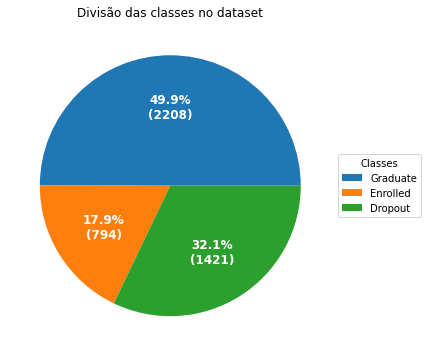

In [ ]:
# Área que plota-se o gráfico e define-se o seu tamanho
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))

# Informações das classes
recipe = ["Graduate",
          "Enrolled",
          "Dropout"]

# Informa-se a quantidade dos dados
data_class = [2209, 794, 1421]

# Mostra a porcentagem de cada classe no dataset
def func(pct, allvals):
    # calc %
    absolute = int(pct/100.*np.sum(allvals))
    # fazendo legenda do gráfico
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Criando o gráfico e colocando a função da legenda interna
wedges, texts, autotexts = ax.pie(data_class, autopct = lambda pct: func(pct, data_class),
                                  textprops=dict(color = "w"))

# Definindo a caixa de legenda externa, título, localização e onde vai 'ancorar o box'
ax.legend(wedges, recipe,
          title="Classes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Aqui definimos o tamanho do texto de dentro do gráfico, e o peso da fonte como bold
plt.setp(autotexts, size=12, weight="bold")

# Título do gráfico
ax.set_title("Divisão das classes no dataset")

# Mostrando o gráfico
plt.show()

#### 3.2 Manipulação dos dados para retirada do desequilíbrio das classes com SMOTE (técnica de sobreamostragem minoritária sintética)

In [ ]:
X_resampled, Y_resampled = SMOTE().fit_resample(X, y)

# Mostra a quantidade de cada classee após a retirada do desequilíbrio.
print('Classes: ', sorted(Counter(Y_resampled).items()))

print('Dimensões do novo dataset: ', X_resampled.shape)

In [ ]:
# Mostrando os atributos após a retirada do desequilíbrio.
X_resampled.head()

# Salvando os atributos balanceados em um novo arquivo csv
atrib = X_resampled
atrib.to_csv('/content/code/atrib.csv')

# Salvando as classes balanceadas em um novo arquivo csv
Y = Y_resampled
Y.to_csv('/content/code/classes.csv')

##### 3.2.1 Comparação das classes após a aplicação da técnica SMOTE.

In [ ]:
# quantidade de classes
grupos = 3

# valores das classes desquilibradas e equilibradas, respectivamente
deseq = (2209, 794, 1421)
equi = (2209, 2209, 2209)

# configurações do gráfico
fig, ax = plt.subplots()
indice = np.arange(grupos)
bar_larg = 0.2
transp = 0.8
plt.bar(indice, deseq, bar_larg, alpha = transp, color="gray", label = 'Desquilibrado')
plt.bar(indice + bar_larg, equi, bar_larg, alpha = transp, color = "black", label = 'Equilibrado')

# informações de título, eixo e legendas    
plt.xlabel('Classes do dataset') 
plt.ylabel('Quatidade de instâncias') 
plt.title('Relação de classes com dataset desequilibrado x equilibrado') 
plt.xticks(indice + bar_larg, ('Graduate', 'Enrolled', 'Dropout')) 
plt.legend() 
plt.tight_layout() 
plt.show()

#### 3.3 Realizando a normalização dos dados antes da validação cruzada dos conjuntos de treino/teste:

#### Para padronizar os dados no intervalo (-1, 1), foi utilizado o ``MaxAbsScaler``.

In [ ]:
# Tipo de normalizador de dados.
norm = MaxAbsScaler()

scaler = norm.fit(X) # Calcula o máximo de cada atributo

# Dados dos atributos normalizados
X_norm = scaler.transform(X)

X_norm

array([[ 0.16666667,  0.29824561,  0.55555556, ...,  0.66666667,
         0.37837838,  0.42857143],
       [ 0.16666667,  0.26315789,  0.11111111, ...,  0.85802469,
        -0.08108108,  0.19458128],
       [ 0.16666667,  0.01754386,  0.55555556, ...,  0.66666667,
         0.37837838,  0.42857143],
       ...,
       [ 0.16666667,  0.01754386,  0.11111111, ...,  0.85802469,
        -0.08108108,  0.19458128],
       [ 0.16666667,  0.01754386,  0.11111111, ...,  0.58024691,
        -0.21621622, -0.76847291],
       [ 0.16666667,  0.1754386 ,  0.11111111, ...,  0.78395062,
         1.        , -0.41871921]])

#### 3.4 Criando o conjunto de treinamento e validação com a função train_test_split

In [ ]:
# Com as classes equilibradas, pode-se utilizar o train_test_split para separar o conjunto de treino e validação
x_train_fold, x_test_fold, y_train_fold, y_test_fold = train_test_split(X_norm, y, test_size = 0.2)

##### 3.4.1 Criando a lista que armazerará os resultados do modelo

In [ ]:
# lista que receberá as acurácias do modelo MLP
rbf_list = []


### 4. Construindo a RNA-RBF:

#### 4.1 Características da RNA RBF:

- ``kernel`` = Se None for passado, o kernel “1.0 * RBF(1.0)”
- ``random_state`` = Determina a geração de números aleatórios usados ​​para inicializar os centros


In [ ]:
# definindo o kernel da rede:
kernel_1 = 1.0 * RBF(5.0)

# modelo rbf_1 com kernel_1
model_rbf = GaussianProcessClassifier(kernel = kernel_1)


# definindo o número de neurônios da camada oculta da RBF.
n = 40

### 5 Validação do modelo da RNA-RBF proposta:

#### 5.1 Processo de treinamento e teste dos modelos através dos ``folds``

In [ ]:

def train_test_model(modelo, lista):

    #pos = np.random.permutation(x_train_fold.shape[0]);
    #centroides = x_train_fold[pos[0:n],:];
    #classes = y_train_fold[pos[0:n]];

    # treino e teste:
    modelo.fit(x_train_fold, y_train_fold);
    y_pred_1 = modelo.predict(x_test_fold)
    lista.append(modelo.score(x_test_fold, y_test_fold))
    
    # Imprime as matrizes de confusão para cada treino e teste do fold = k...k-1.
    def accuracy(confusion_matrix):
      diagonal_sum = confusion_matrix.trace()
      sum_of_all_elements = confusion_matrix.sum()
      return diagonal_sum / sum_of_all_elements

    fig = plot_confusion_matrix(modelo, x_test_fold, y_test_fold, display_labels = modelo.classes_)
    fig.figure_.suptitle("Matriz de confusão com Stratified Kfold")
    plt.show();

# Método que calcula a precisão dos modelos das redes MLP.
def results_model(modelo, lista):
  # Mostra o resultado das acurácias calculadas pelo modelo.
  print(' ------------------- Resultados obtidos do modelo ------------------------------------ \n')
  print('\nAcurácia média do modelo: {:.2f}%'.format(mean(lista)*100, '%'))
  print('---------------------------------------------------------------------------------------\n'))



#### 5.2 Matriz de Confusão e medidas de classificação da MLP

##### 5.2.1 **Matrizes de confusão e medidas de acurácia para a rede RBF**

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


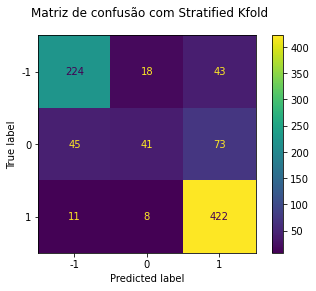

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


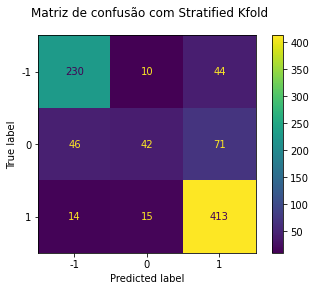

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


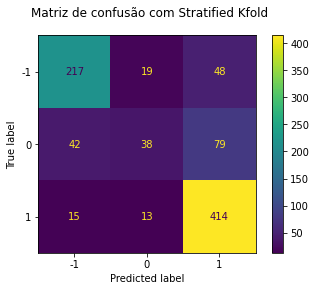

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


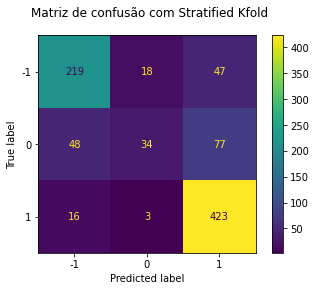

In [ ]:
train_test_model(model_rbf, rbf_list);

In [ ]:
results_model(model_rbf, rbf_list);

 ------------------- Resultados obtidos do modelo 1 com função de ativação --------------------- 

Lista de possíveis acurácias do modelo:  [0.7762711864406779, 0.7740112994350282, 0.7559322033898305, 0.7638418079096045, 0.7579185520361991]

Acurácia máxima que pode ser obtida por esse modelo: 77.63%

Acurácia mínima: 75.59%

Acurácia média do modelo: 76.56%

Desvio padrão: 0.00922206900960896
-----------------------------------------------------------------------------------------------------------------------------------

